In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
from tqdm import tqdm

In [8]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, 3)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                #print(reshaped_tile.shape)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile[:,:,4:1:-1]
                    b += 1
        yield (image_batch, label_batch)
        
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count_per_dataset)
        
        dataset_index_list = [index] * total_count_per_dataset
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_pixels += dataset_pixels[:train_count_per_dataset]
        val_pixels += dataset_pixels[train_count_per_dataset:]
        
        
    return (train_pixels, val_pixels)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [3]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.inception_v3 import InceptionV3

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [87]:
input_shape = (75,75,3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

In [88]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(23, activation='softmax')(x)
inception_model = keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [89]:
#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']
inception_model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=metrics)


In [7]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))

In [71]:
batch_size = 1000
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))
epochs = 50

# input image dimensions
tile_side = 75

In [78]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 37, 37, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 37, 37, 32)   96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 37, 37, 32)   0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

In [73]:
train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=50000, val_count=5000, tile_size=tile_side)

100%|██████████| 4/4 [00:45<00:00, 11.26s/it]


In [90]:
inception_model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=50, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size,
                    class_weight=class_weights)

Epoch 1/50
50/50 [==============================] - 113s 2s/step - loss: 2.3597 - acc: 0.2825 - val_loss: 3.3709 - val_acc: 0.2414
Epoch 2/50
50/50 [==============================] - 93s 2s/step - loss: 2.1278 - acc: 0.3104 - val_loss: 3.0275 - val_acc: 0.2284
Epoch 3/50
50/50 [==============================] - 98s 2s/step - loss: 2.0410 - acc: 0.3279 - val_loss: 3.1056 - val_acc: 0.1894
Epoch 4/50
 8/50 [===>..........................] - ETA: 1:35 - loss: 2.0322 - acc: 0.3386

KeyboardInterrupt: 

In [21]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [22]:
for layer in inception_model.layers[:249]:
    layer.trainable = False
for layer in inception_model.layers[249:]:
    layer.trainable = True

In [29]:
inception_model.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=metrics)


In [24]:
inception_model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=50, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50
200/200 [==============================] - 29s 144ms/step - loss: 0.0925 - val_loss: 11.8802
Epoch 2/50
200/200 [==============================] - 15s 73ms/step - loss: 0.1194 - val_loss: 11.7619
Epoch 3/50
200/200 [==============================] - 15s 74ms/step - loss: 0.0566 - val_loss: 11.3576
Epoch 4/50
200/200 [==============================] - 15s 73ms/step - loss: 0.0910 - val_loss: 11.2776
Epoch 5/50
200/200 [==============================] - 15s 73ms/step - loss: 0.0755 - val_loss: 12.0530
Epoch 6/50
200/200 [==============================] - 14s 72ms/step - loss: 0.0792 - val_loss: 11.4591
Epoch 7/50
200/200 [==============================] - 14s 72ms/step - loss: 0.0752 - val_loss: 11.0519
Epoch 8/50
200/200 [==============================] - 15s 73ms/step - loss: 0.0657 - val_loss: 11.7521
Epoch 9/50
200/200 [==============================] - 15s 73ms/step - loss: 0.0577 - val_loss: 11.8887
Epoch 10/50
200/200 [==============================] - 15s 73ms/step - l

In [27]:
test_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=5000, val_count=0, tile_size=tile_side)

100%|██████████| 4/4 [00:59<00:00, 14.89s/it]


In [30]:
inception_model.evaluate_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

200/200 [==============================] - 21s 103ms/step


[11.25083693742752, 0.17279999811202287]

<BarContainer object of 23 artists>

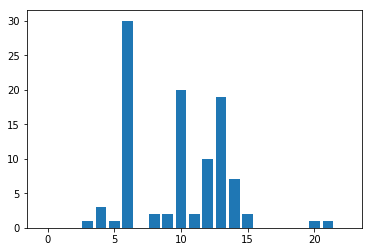

In [67]:
count = 0
classes = np.zeros(23)
for x in tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, test_px, 1):
    if count > 100:
        break
    classes[np.where(x[1]>0)[1]] += 1
    count+=1
plt.bar(np.arange(23),classes)

<BarContainer object of 23 artists>

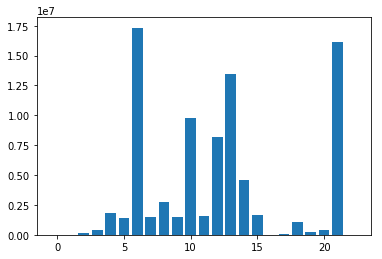

In [66]:
total_counts = np.zeros(23)
for i in range(2,23):
    total_counts[i] = len(np.where(label_image == i)[0])
plt.bar(np.arange(23),total_counts)

In [64]:
len(total_counts)

23

In [85]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(label_image), np.ravel(label_image))

In [86]:
class_weights

array([9.45440165e-02, 1.40289867e-01, 1.02229135e+02, 4.01745361e+01,
       8.49967596e+00, 1.13010189e+01, 9.15229899e-01, 1.08806948e+01,
       5.85763056e+00, 1.06874402e+01, 1.62748582e+00, 9.99339328e+00,
       1.93763546e+00, 1.17595169e+00, 3.47239908e+00, 9.79855601e+00,
       1.92086811e+04, 3.00164033e+02, 1.48855750e+01, 5.90825058e+01,
       3.66828751e+01, 9.80978671e-01, 3.01642027e+04])

In [93]:
label_image[0, :10000, :10000]

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  6,  6, 13],
       [ 1,  1,  1, ...,  6,  6, 12],
       [ 1,  1,  1, ...,  6,  6,  6]], dtype=uint8)